# Problem Set 3

## Question 1. Consumption Insurance Tests. Individual insurance in log-level changes

In [1]:
import statsmodels.formula.api as sm
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.2f}'.format
os.chdir('C:/Users/alena/Desktop/Development/PS3')

In [2]:
data = pd.read_stata("dataUGA.dta")
data = data[["hh", "age", "age_sq", "familysize", "sex","worker", "writeread", "urban", "region2", "region3", "region4", "ctotal", "cnodur", "inctotal", "month", "year", "wave"]]
data = pd.concat([data, pd.get_dummies(data.year)], axis=1)
data.columns
data.wave.unique()
data.loc[data.wave=='2009-2010', 'year']=2009
data.loc[data.wave=='2010-2011', 'year']=2010
data.loc[data.wave=='2011-2012', 'year']=2011
data.loc[data.wave=='2013-2014', 'year']=2013

Individual insurance in log-level changes:

$ \Delta ln c_{it} = cons + \alpha \Delta ln N_{it} + \beta_{i} \Delta ln y_{it} + \phi_{i} \Delta ln \bar{C} +\epsilon$

where $c_{it}$ and $y_{it}$ are household-level consumption and income of household $i$ in period $t$, respectively, and $\bar{C}$ is aggregate consumption.

In [3]:
model_C = sm.OLS(data.cnodur,data[["age", "age_sq", "familysize", "sex","worker", "writeread", "urban", "region2", "region3", "region4", 2009, 2010.0, 2011.0, 2012.0, 2013]],missing = 'drop')
result_C = model_C.fit()
model_Y = sm.OLS(data.inctotal,data[["age", "age_sq", "familysize", "sex","worker", "writeread", "urban", "region2", "region3", "region4", 2009, 2010.0, 2011.0, 2012.0, 2013]],missing = 'drop')
result_Y = model_Y.fit()

In [4]:
data = pd.concat([data,result_C.resid,result_Y.resid], axis=1)
data = data[["hh", "urban","ctotal", "cnodur", "inctotal", "month", "year", "wave", 0,1]]
data.columns = ["hh", "urban","ctotal", "cnodur", "inctotal", "month", "year", "wave", "c","y"]
data.c = data.c.fillna(data.c.mean())
data.y = data.y.fillna(data.y.mean())

In [5]:
#pivot
wide = data.pivot(index="hh", columns="wave", values=["c","y"])
wide.columns = ["c2009","c2010","c2011","c2013","y2009","y2010","y2011","y2013"]

#replace zeros
wide.c2009 = wide.c2009.replace(0,np.nan)
wide.c2010 = wide.c2010.replace(0,np.nan)
wide.c2011 = wide.c2011.replace(0,np.nan)
wide.c2013 = wide.c2013.replace(0,np.nan)
wide.y2009 = wide.y2009.replace(0,np.nan)
wide.y2010 = wide.y2010.replace(0,np.nan)
wide.y2011 = wide.y2011.replace(0,np.nan)
wide.y2013 = wide.y2013.replace(0,np.nan)

#fill nans
wide.c2009 = wide.c2009.fillna(wide.c2009.mean())
wide.c2010 = wide.c2010.fillna(wide.c2010.mean())
wide.c2011 = wide.c2011.fillna(wide.c2011.mean())
wide.c2013 = wide.c2013.fillna(wide.c2013.mean())
wide.y2009 = wide.y2009.fillna(wide.y2009.mean())
wide.y2010 = wide.y2010.fillna(wide.y2010.mean())
wide.y2011 = wide.y2011.fillna(wide.y2011.mean())
wide.y2013 = wide.y2013.fillna(wide.y2013.mean())

#calculate differences
wide.c2009 = wide.c2010-wide.c2009
wide.c2010 = wide.c2011-wide.c2010
wide.c2011 = wide.c2013-wide.c2011
wide.y2009 = wide.y2010-wide.y2009
wide.y2010 = wide.y2011-wide.y2010
wide.y2011 = wide.y2013-wide.y2011

wide = wide.drop(["c2013", "y2013"], axis=1)
wide = wide.reset_index()

In [6]:
long = pd.wide_to_long(wide, stubnames=["c","y"], i="hh", j="year", sep="")
long = long.reset_index()

In [7]:
#merge datasets
data2 = pd.merge(data.drop(["c","y"], axis=1), long, on=["hh", "year"], how="left")

#remove outliers
data2[["c","y"]] = data2.loc[(data2.c>data2.c.quantile(q=0.05)) & (data2.c<data2.c.quantile(q=0.98))&(data2.y>data2.y.quantile(q=0.05)) & (data2.y<data2.y.quantile(q=0.98)),["c", "y"]]

#drop nans
data2 = data2.dropna()

In [8]:
#aggregate C and Y
data2.loc[data2.year==2009,"C_agg"] = data2.loc[data2.year==2009,"cnodur"].sum()
data2.loc[data2.year==2010,"C_agg"] = data2.loc[data2.year==2010,"cnodur"].sum()
data2.loc[data2.year==2011,"C_agg"] = data2.loc[data2.year==2011,"cnodur"].sum()

In [9]:
HHs = data2.hh.unique()
#remove hh without full obs
for h in range(len(HHs)):
    data2.loc[data2.hh==HHs[h],"count"] = data2.loc[data2.hh==HHs[h],"hh"].count()

data2 = data2.loc[data2["count"]==3,]

In [10]:
#regressions per HHs
HHs = data2.hh.unique()
model_HH = []
for h in range(len(HHs)):
    model_HH.append(sm.OLS(data2.loc[data2.hh==HHs[h], "c"], data2.loc[data2.hh==HHs[h], ["y","C_agg"]]).fit())
    
beta=[]
gamma=[]
for h in range(len(HHs)):
    beta.append(model_HH[h].params[0])
    gamma.append(model_HH[h].params[1])

Text(0.5,1,'Histogram of betas')

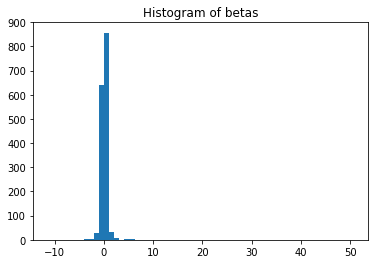

In [30]:
plt.hist(beta, bins=60)
plt.title("Histogram of betas")

As we can see distribution of the coefficient $\beta$ for individual income is around 0, but the mean value of $\beta$ is equal to $0.18$, so in this case the full-risk insurance in individual income is not achieved.

In [12]:
np.mean(beta)

0.17792841342085675

Text(0.5,1,'Histogram of gammas')

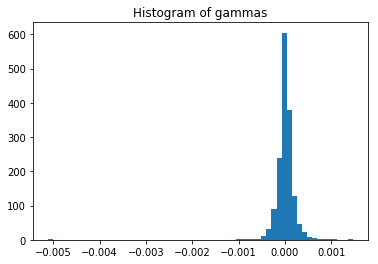

In [31]:
plt.hist(gamma, bins=60)
plt.title("Histogram of gammas")

In [14]:
np.mean(gamma)

1.0304049937953363e-05

The distribuation of $\phi$ for aggregate consumption is also distributed around zero, and mean is close to zero as well. According to theory this value should be equal to 1. In our case the coefficient is very close to zero, which means that aggregate consumption does not have significant influence.

## Question 2. On the relationship between insurance and income/wealth

In [15]:
#calculate average income per HH
for h in range(len(HHs)):
    data2.loc[data2.hh==HHs[h],"Y_avg"] = data2.loc[data2.hh==HHs[h],"inctotal"].mean()

#rank HHs by income
data2.loc[data2.Y_avg>data2.Y_avg.quantile(q=0.8),"inc_rank"] = 1
data2.loc[(data2.Y_avg>data2.Y_avg.quantile(q=0.6))&(data2.Y_avg<=data2.Y_avg.quantile(q=0.8)),"inc_rank"] = 2
data2.loc[(data2.Y_avg>data2.Y_avg.quantile(q=0.4))&(data2.Y_avg<=data2.Y_avg.quantile(q=0.6)),"inc_rank"] = 3
data2.loc[(data2.Y_avg>data2.Y_avg.quantile(q=0.2))&(data2.Y_avg<=data2.Y_avg.quantile(q=0.4)),"inc_rank"] = 4
data2.loc[(data2.Y_avg<=data2.Y_avg.quantile(q=0.2)),"inc_rank"] = 5

#model by income
model_rank = []
beta_rank=[]
gamma_rank=[]
for r in range(1,6):
    model_rank.append(sm.OLS(data2.loc[data2.inc_rank==r, "c"], data2.loc[data2.inc_rank==r, ["y","C_agg"]]).fit())
    beta_rank.append(model_rank[r-1].params[0])
    gamma_rank.append(model_rank[r-1].params[1])

Text(0.5,0,'Rank of income: 1-the richest, 5-the poorest')

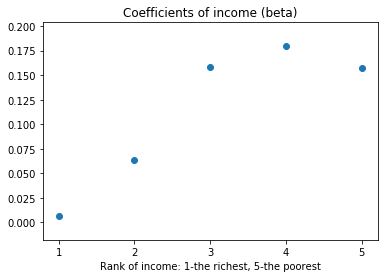

In [32]:
plt.scatter(range(1,6),beta_rank)
plt.title('Coefficients of income (beta)')
plt.xticks(range(1,6))
plt.xlabel('Rank of income: 1-the richest, 5-the poorest')

We defined 5 groups of income from bottom 20% to richest 20% (1 - the richest and 5 - the poorest) and plotted the coeficient $\beta$ for income. 

As we can see for the richest group the coefficient is closest to zero, so that richer group of people are better in risk-sharing. Groups 3, 4 and 5 have the highest value of the coefficient - above 0.15.

Text(0.5,0,'Rank of income: 1-the richest, 5-the poorest')

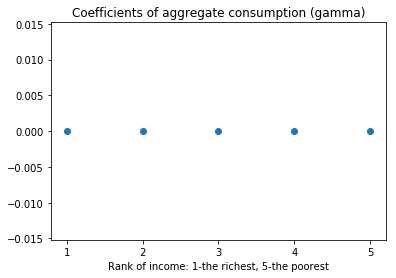

In [33]:
plt.scatter(range(1,6),gamma_rank)
plt.title('Coefficients of aggregate consumption (gamma)')
plt.xticks(range(1,6))
plt.xlabel('Rank of income: 1-the richest, 5-the poorest')

Values of the coefficient for the aggregate consumption are almost the same for all of the defined groups of the population.

## Question 3. Modify the previous test in (1) assuming that the coeficients are the same across households, so that household variation helps pin down the estimates,


$ \Delta ln c_{it} = cons + \alpha \Delta ln N_{it} + \beta \Delta ln y_{it} + \phi \Delta ln \bar{C} +\epsilon$

In [18]:
#######################
# question 3
model_3 = sm.OLS(data2["c"], data2[["y","C_agg"]]).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      c   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     112.6
Date:                Wed, 27 Feb 2019   Prob (F-statistic):           1.60e-48
Time:                        12:28:15   Log-Likelihood:                -34935.
No. Observations:                4746   AIC:                         6.987e+04
Df Residuals:                    4744   BIC:                         6.989e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
y              0.0731      0.005     13.658      0.000       0.063       0.084
C_agg       2.237e-05   4.54e-06      4.931      0.000    1.35e-05    3.13e-05
==============================================================================
Omnibus:                      128.430   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              223.658
Skew:                           0.228   Prob(JB):                     2.71e-49
Kurtosis:                       3.961   Cond. No.                     1.19e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Full-risk sharing is also almost achieved for individual income assuming that the coeficients are the same across households. Coefficient $\beta$ is equal to $0.073$ for individual income.

## Question 4.  Redo items 1 and 2 for rural and urban areas separately.

Comparing the result for rural and urban areas separately we can see the following:

- In urban areas mean $\beta$ is 0.2, for rural 0.1, which means that in rural areas households are slightly better in risk-sharing.
- If looking at the poorest groups in urban and rural areas: in urban areas coefficient for individual income for the poorest group is 0.23, and in rural 0.15 (which means that poor people in rural areas are better in risk-sharing) and for the richest, in urban areas it is 0.05 and in rural almost zero (and again in rural areas rich people are better in risk-sharing than in urban). There is larger difference for middle class (group 3): in urban it is higher than 0.25 and in rural 0.12.
- Overall across different groups of population we can see that in rural areas people are better in risk-sharing.
- Coefficients for aggregate are almost the same across all the groups and areas, close to zero, which means that aggregate consumption for the whole population does not have a significant influence.


## Urban

In [19]:
# Urban
data_urban = data2.loc[data2.urban==1,]

#regressions per HHs
HHs = data_urban.hh.unique()
model_urban = []
for h in range(len(HHs)):
    model_urban.append(sm.OLS(data_urban.loc[data_urban.hh==HHs[h], "c"], data_urban.loc[data_urban.hh==HHs[h], ["y","C_agg"]]).fit())

beta_urban=[]
gamma_urban=[]
for h in range(len(HHs)):
    beta_urban.append(model_urban[h].params[0])
    gamma_urban.append(model_urban[h].params[1])

Text(0.5,1,'Histogram of urban betas')

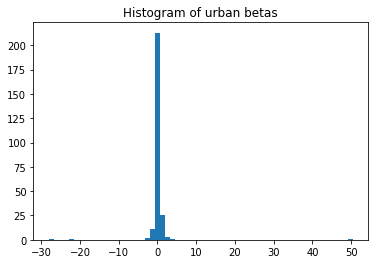

In [34]:
plt.hist(beta_urban, bins=60)
plt.title("Histogram of urban betas")

In [21]:
np.mean(beta_urban)

0.20301080642310904

Text(0.5,1,'Histogram of urban gammas')

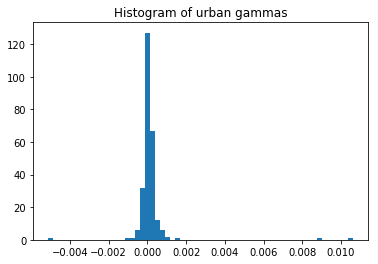

In [35]:
plt.hist(gamma_urban, bins=60)
plt.title("Histogram of urban gammas")

In [23]:
np.mean(gamma_urban)

0.00013340478233319603

In [24]:
#model by income
model_rank_urban = []
beta_rank_urban=[]
gamma_rank_urban=[]
for r in range(1,6):
    model_rank_urban.append(sm.OLS(data_urban.loc[data_urban.inc_rank==r, "c"], data_urban.loc[data_urban.inc_rank==r, ["y","C_agg"]]).fit())
    beta_rank_urban.append(model_rank_urban[r-1].params[0])
    gamma_rank_urban.append(model_rank_urban[r-1].params[1])

([<matplotlib.axis.XTick at 0x1baba452a20>,
 <a list of 5 Text xticklabel objects>)

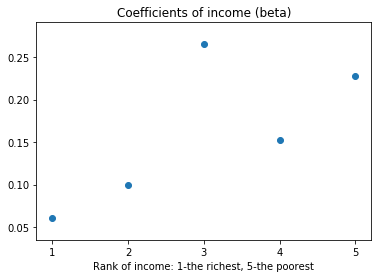

In [25]:
plt.scatter(range(1,6),beta_rank_urban)
plt.title('Coefficients of income (beta)')
plt.xticks(range(1,6))
plt.xlabel('Rank of income: 1-the richest, 5-the poorest')

([<matplotlib.axis.XTick at 0x1baba49b390>,
 <a list of 5 Text xticklabel objects>)

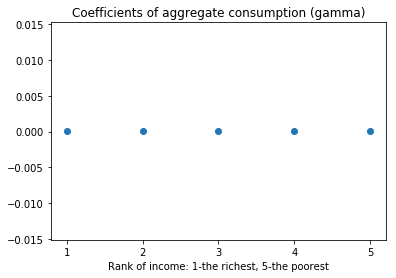

In [26]:
plt.scatter(range(1,6),gamma_rank_urban)
plt.title('Coefficients of aggregate consumption (gamma)')
plt.xticks(range(1,6))
plt.xlabel('Rank of income: 1-the richest, 5-the poorest')

## Rural

In [36]:
data_rural = data2.loc[data2.urban==0,]

#regressions per HHs
HHs = data_rural.hh.unique()
model_rural = []
for h in range(len(HHs)):
    model_rural.append(sm.OLS(data_rural.loc[data_rural.hh==HHs[h], "c"], data_rural.loc[data_rural.hh==HHs[h], ["y","C_agg"]]).fit())

beta_rural=[]
gamma_rural=[]
for h in range(len(HHs)):
    beta_rural.append(model_rural[h].params[0])
    gamma_rural.append(model_rural[h].params[1])

Text(0.5,1,'Histogram of rural betas')

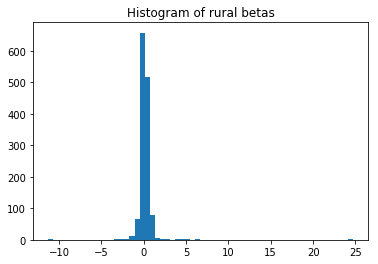

In [41]:
plt.hist(beta_rural, bins=60)
plt.title("Histogram of rural betas")

In [38]:
np.mean(beta_rural)

0.13059701916845898

Text(0.5,1,'histogram of rural gammas')

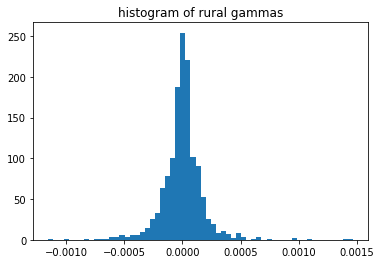

In [42]:
plt.hist(gamma_rural, bins=60)
plt.title("histogram of rural gammas")

In [40]:
np.mean(gamma_rural)

4.5203380833257023e-07

In [ ]:
#model by income
model_rank_rural = []
beta_rank_rural=[]
gamma_rank_rural=[]
for r in range(1,6):
    model_rank_rural.append(sm.OLS(data_rural.loc[data_rural.inc_rank==r, "c"], data_rural.loc[data_rural.inc_rank==r, ["y","C_agg"]]).fit())
    beta_rank_rural.append(model_rank_rural[r-1].params[0])
    gamma_rank_rural.append(model_rank_rural[r-1].params[1])

Text(0.5,0,'Rank of income: 1-the richest, 5-the poorest')

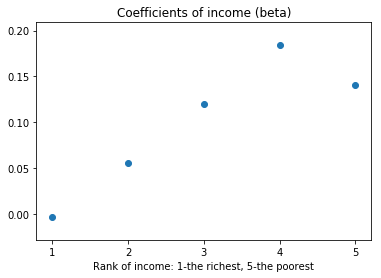

In [43]:
plt.scatter(range(1,6),beta_rank_rural)
plt.title('Coefficients of income (beta)')
plt.xticks(range(1,6))
plt.xlabel('Rank of income: 1-the richest, 5-the poorest')

Text(0.5,0,'Rank of income: 1-the richest, 5-the poorest')

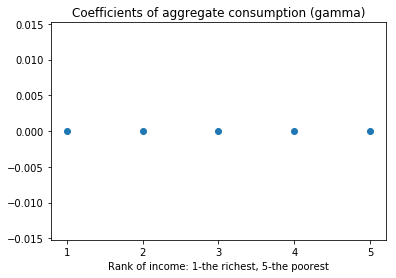

In [44]:
plt.scatter(range(1,6),gamma_rank_rural)
plt.title('Coefficients of aggregate consumption (gamma)')
plt.xticks(range(1,6))
plt.xlabel('Rank of income: 1-the richest, 5-the poorest')